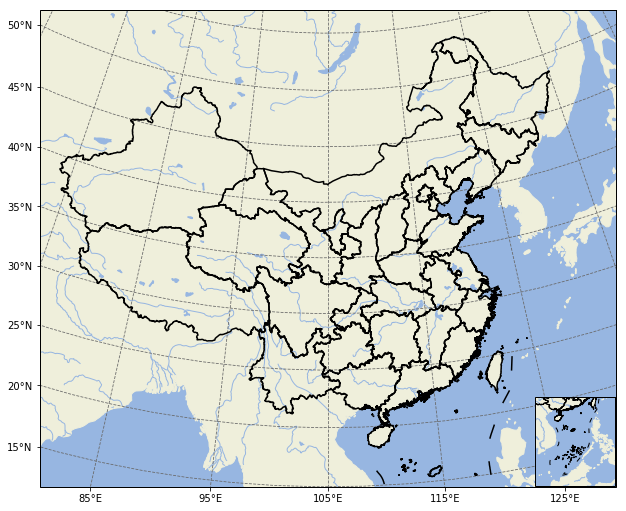

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from copy import copy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom



def find_side(ls, side):
    """
 Given a shapely LineString which is assumed to be rectangular, return the
 line corresponding to a given side of the rectangle.

 """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible: 
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels


# Load the border data, CN-border-La.dat is downloaded from
# https://gmt-china.org/data/CN-border-La.dat
with open('CN-border-La.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

    
# Set figure size
proj = ccrs.LambertConformal(central_longitude=105, central_latitude=90,
                             false_easting=400000, false_northing=400000)#,standard_parallels=(46, 49))

fig = plt.figure(figsize=[10, 8],frameon=True)


# Set projection and plot the main figure
ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
# Set figure extent
ax.set_extent([80, 130, 15, 55],crs=ccrs.PlateCarree())

# Plot border lines
for line in borders:
    ax.plot(line[0::2], line[1::2], '-', lw=1.5, color='k',
            transform=ccrs.Geodetic())

# Add ocean, land, rivers and lakes
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))


# *must* call draw in order to get the axis boundary used to add ticks:
fig.canvas.draw()

# Define gridline locations and draw the lines using cartopy's built-in gridliner:
# xticks = np.arange(80,130,10)
# yticks = np.arange(15,55,5)
xticks = [55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165]
yticks = [0 , 5 , 10, 15, 20, 25 , 30 , 35 , 40 , 45 , 50 , 55 , 60 , 65]
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)


#Plot South China Sea as a subfigure
sub_ax = fig.add_axes([0.754, 0.107, 0.14, 0.155],
                      projection=ccrs.LambertConformal(central_latitude=90,
                                                       central_longitude=115))
# Add ocean, land, rivers and lakes
sub_ax.add_feature(cfeature.OCEAN.with_scale('50m'))
sub_ax.add_feature(cfeature.LAND.with_scale('50m'))
sub_ax.add_feature(cfeature.RIVERS.with_scale('50m'))
sub_ax.add_feature(cfeature.LAKES.with_scale('50m'))
# Plot border lines
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',
                transform=ccrs.Geodetic())
# Set figure extent
sub_ax.set_extent([105, 125, 0, 25],crs=ccrs.PlateCarree())

# Show figure
plt.savefig("China_nine_lines_lambert.png", dpi=500, bbox_inches='tight')
plt.show()